# Change Detection with DEMs

## Introduction

Add prose

- Insperation for study area
- Link to fridge

## Study Area

In [1]:
from pathlib import Path
import geopandas as gpd

# Create a GeoDataFrame from the GeoJson aoi file adjacent to this notebook
AOI_GEOJSON = Path(__name__).resolve().parent / "aoi.geojson"
aoi: gpd.GeoDataFrame = gpd.read_file(AOI_GEOJSON)

In [2]:
aoi.head()

,name,geometry
0,Area of Interest,"POLYGON ((-147.07638 61.11004, -147.27669 61.0..."


In [3]:
import leafmap


def initialize_default_interactive_map() -> leafmap.Map:
    # Initialize a default Map
    m = leafmap.Map()

    # Add helpful GUI elements to the map interface
    m.add_gui(name="layer_manager", position="topright", opened=False)

    return m

In [4]:
from pathlib import Path
import leafmap


def create_interactive_aoi_map(aoi_geojson: Path) -> leafmap.Map:
    m = initialize_default_interactive_map()

    # Add data to the map. Each call to m.add_<something> places that data on the top of
    # the visual hierarchy. Therefore we will generally want to add basemaps first, rasters
    # second, and vectors last.

    # Add relevant basemaps
    m.add_basemap("Esri.WorldImagery", show=True)
    m.add_basemap("USGS.USImagery", show=False)

    # No raster data yet

    # Add vector data
    m.add_geojson(str(aoi_geojson), layer_name="Area of Interest", zoom_to_layer=True)

    return m


interactive_map = create_interactive_aoi_map(AOI_GEOJSON)
interactive_map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [5]:
# del interactive_map

## Finding Strip DEMs

In [6]:
from pathlib import Path
import requests


def download_strip_index_archive(url: str, output_dir: Path) -> Path:
    # Make sure the output directory exists
    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    # Download the zip archive to the output directory
    r = requests.get(url, stream=True)

    # Throw an Exception if the request returned an error status
    r.raise_for_status()

    # Write the archive to the filesystem
    archive = output_dir / "strip_index_archive.zip"
    with open(archive, "wb") as f:
        for chunk in r.iter_content(chunk_size=128):
            f.write(chunk)

    return archive

In [7]:
import shutil


def unzip_strip_index_archive(archive: Path) -> Path:
    shutil.unpack_archive(filename=archive, extract_dir=archive.parent)

In [8]:
STRIP_INDEX_ARCHIVE_URL = "https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Strip_Index_latest_gpqt.zip"
STRIP_DIR = Path(__name__).resolve().parent / "data/strips/"

strip_index_archive = download_strip_index_archive(
    url=STRIP_INDEX_ARCHIVE_URL, output_dir=STRIP_DIR
)

In [9]:
unzip_strip_index_archive(archive=strip_index_archive)

In [10]:
from pathlib import Path

import pdemtools as pdt
from shapely import Polygon


def get_intersecting_strips(
    strip_index: Path, bounds: Polygon, min_aoi_frac: float
) -> gpd.GeoDataFrame:
    strips: gpd.GeoDataFrame = pdt.search(
        index_fpath=str(strip_index),
        bounds=bounds,
        min_aoi_frac=min_aoi_frac,
    )

    return strips.sort_values("acqdate1")

In [11]:
strip_index = list(STRIP_DIR.glob("*/*.parquet"))[0]

bounds: Polygon = aoi.to_crs("EPSG:3413").iloc[0].geometry

strips = get_intersecting_strips(
    strip_index=strip_index, bounds=bounds, min_aoi_frac=0.90
)
print(f"Found {strips.shape[0]} strips matching the search criteria")

Found 28 strips matching the search criteria


In [12]:
strips.head()

,fid,dem_id,pairname,stripdemid,sensor1,sensor2,catalogid1,catalogid2,acqdate1,acqdate2,...,cloud_area_sqkm,cloud_area_percent,avg_convergence_angle,avg_expected_height_accuracy,avg_sun_elev1,avg_sun_elev2,rmse,fileurl,s3url,geom
375797,375798,SETSM_s2s041_GE01_20120616_1050410000CCCE00_10...,GE01_20120616_1050410000CCCE00_1050410000CAD600,GE01_20120616_1050410000CCCE00_1050410000CAD60...,GE01,GE01,1050410000CCCE00,1050410000CAD600,2012-06-16 20:51:00,2012-06-16 20:50:05,...,190.363244,0.422274,-9999.000000,-9999.000000,51.066667,51.000000,1.890100,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,"POLYGON ((-3112793.238 679439.148, -3112793.23..."
375815,375816,SETSM_s2s041_GE01_20120813_1050410000829A00_10...,GE01_20120813_1050410000829A00_1050410000759100,GE01_20120813_1050410000829A00_105041000075910...,GE01,GE01,1050410000829A00,1050410000759100,2012-08-13 21:03:40,2012-08-13 21:02:51,...,48.151820,0.127937,-9999.000000,-9999.000000,42.466667,42.433333,1.099500,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,"POLYGON ((-3114586.000 679052.000, -3112793.23..."
375788,375789,SETSM_s2s041_GE01_20121012_1050410000283800_10...,GE01_20121012_1050410000283800_105041000027B200,GE01_20121012_1050410000283800_105041000027B20...,GE01,GE01,1050410000283800,105041000027B200,2012-10-12 20:49:32,2012-10-12 20:48:38,...,77.422264,0.168067,-9999.000000,-9999.000000,20.666667,20.633333,1.282000,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,"POLYGON ((-3124224.238 679859.654, -3112793.23..."
375722,375723,SETSM_s2s041_WV01_20130610_1020010020861300_10...,WV01_20130610_1020010020861300_1020010024444C00,WV01_20130610_1020010020861300_1020010024444C0...,WV01,WV01,1020010020861300,1020010024444C00,2013-06-10 21:20:08,2013-06-10 21:20:53,...,107.061772,0.172530,36.385234,1.075711,51.800000,51.830001,0.628011,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,"POLYGON ((-3112793.238 678400.589, -3112793.23..."
375799,375800,SETSM_s2s041_WV02_20130712_103001002578FB00_10...,WV02_20130712_103001002578FB00_1030010024C0FD00,WV02_20130712_103001002578FB00_1030010024C0FD0...,WV02,WV02,103001002578FB00,1030010024C0FD00,2013-07-12 22:04:24,2013-07-12 22:03:24,...,84.499264,0.136048,30.387618,1.301678,50.830001,50.870000,0.791388,https://data.pgc.umn.edu/elev/dem/setsm/Arctic...,https://polargeospatialcenter.github.io/stac-b...,"POLYGON ((-3114324.000 679188.000, -3112793.23..."


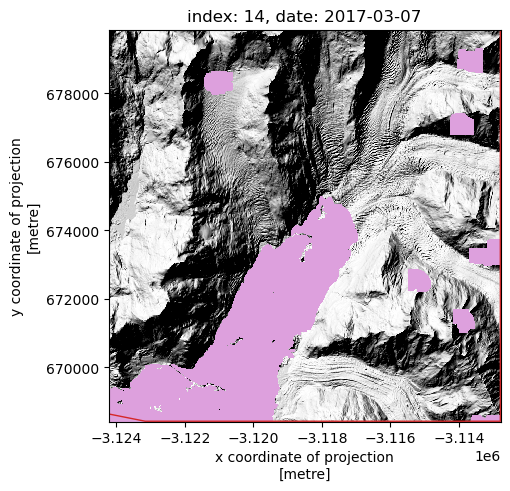

In [13]:
import matplotlib.pyplot as plt


def preview_strip(strips: gpd.GeoDataFrame, bounds: Polygon, index: int) -> plt.figure:
    row = strips.iloc[[index]]
    preview = pdt.load.preview(row, bounds)
    plt.close()
    fig, ax = plt.subplots(layout="constrained")
    ax.set_facecolor("plum")
    preview.plot(cmap="Greys_r", add_colorbar=False)
    row.plot(ax=ax, fc="none", ec="tab:red")
    ax.set_title(f"index: {index}, date: {row.acqdate1.dt.date.values[0]}")

    return fig


f = preview_strip(strips, bounds, 14)

In [14]:
# STRIP_PREVIEWS_DIR = Path(__name__).resolve().parent / "data/strip_previews"

# if not STRIP_PREVIEWS_DIR.exists():
#     STRIP_PREVIEWS_DIR.mkdir(parents=True)

# for index in range(strips.shape[0]):
#     title = strips.iloc[[index]].acqdate1.dt.date.values[0]
#     filepath = STRIP_PREVIEWS_DIR / f"{title}.png"
#     f = preview_strip(strips, bounds, index)
#     f.savefig(filepath, format="png")

In [15]:
selected_rows = [
    strips.iloc[[1]],
    strips.iloc[[21]],
]

In [16]:
STRIP_DIR = Path(__name__).resolve().parent / "data/strips"

if not STRIP_DIR.exists():
    STRIP_DIR.mkdir(parents=True)


def download_strip(row: gpd.GeoDataFrame, bounds: Polygon, output_dir: Path):
    filename = f"{row.acqdate1.dt.date.values[0]}.tif"
    filepath = output_dir / filename
    dem = pdt.load.from_search(row, bounds, bitmask=True)
    dem.compute()
    dem.rio.to_raster(filepath)

In [17]:
# for row in selected_rows:
#     download_strip(row, bounds, STRIP_DIR)

## Backgound Data

In [18]:
from dataclasses import dataclass

import pystac


@dataclass(frozen=True)
class PCCollectionInfo:
    """Data container for storing relevant metadata for using assets in MicroSoft's Planetary Computer STAC Catalogs"""

    collection: str
    asset_stac_key: str
    docs_url: str

    def get_asset_url(self, item: pystac.Item) -> str:
        return item.assets[self.asset_stac_key].href

In [19]:
import geopandas as gpd
import pystac_client
from pystac_client.item_search import ItemCollection


def search_planetary_computer_stac(
    collection: str,
    features: gpd.GeoDataFrame,
) -> ItemCollection:
    STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"

    dissolved_geom: gpd.GeoDataFrame = features.dissolve().iloc[0].geometry

    catalog = pystac_client.Client.open(STAC_URL)
    search = catalog.search(collections=[collection], intersects=dissolved_geom)
    return search.item_collection()

In [20]:
import pystac


def get_asset_href(item: pystac.Item, asset_stac_key: str) -> str:
    return item.assets[asset_stac_key].href

In [21]:
from pathlib import Path
import rioxarray


def download_raster(url: str, dst: Path) -> Path:
    # Make sure the dst directory exists
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)

    # Open the remote raster as a DataArray using the chunking to prevent loading
    # of the entire raster at once
    xds = rioxarray.open_rasterio(url, chunks=True)

    # Write the raster to the filesystem
    xds.rio.to_raster(dst)

    # Return the path to the downloaded raster
    return dst

In [22]:
from pathlib import Path
import geopandas as gpd
import rioxarray
import pdemtools as pdt


def clip_raster(src: Path, dst: Path, aoi: gpd.GeoDataFrame) -> Path:
    # Determine the clipping bounds in the src crs from the provided aoi
    xds = rioxarray.open_rasterio(src)
    src_crs = xds.rio.crs
    bounds = aoi.to_crs(src_crs).iloc[0].geometry

    # Load a clipped version of the raster
    xds = pdt.load.from_fpath(dem_fpath=src, bounds=bounds)

    # Write the clipped raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the clipped raster
    return dst

In [23]:
from pathlib import Path
import rioxarray
from rasterio.enums import Resampling


def reproject_raster(
    src: Path,
    dst: Path,
    dst_epsg: int,
    dst_nodata: float | int,
    resampling_method: Resampling,
) -> Path:
    # Load the src raster as a DataArray
    xds = rioxarray.open_rasterio(src)

    # Reproject to the dst crs, filling around the edges with the specified nodata value
    xds = xds.rio.reproject(
        dst_crs=f"EPSG:{dst_epsg}", resampling=resampling_method, nodata=dst_nodata
    )

    # Write the reprojected raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the reprojected raster
    return dst

In [24]:
cop30_info = PCCollectionInfo(
    collection="cop-dem-glo-30",
    asset_stac_key="data",
    docs_url="https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30",
)

In [25]:
cop30_items = search_planetary_computer_stac(
    collection=cop30_info.collection,
    features=aoi,
)
cop30_items

In [26]:
DATA_DIR = Path(__name__).parent / "data"

# Extract collection constants to local variable for readability
collection = cop30_info.collection
url = cop30_info.get_asset_url(item=cop30_items[0])

# Define the destination path for each raster stage
downloaded_dst = DATA_DIR / "background" / f"{collection}.tif"
clipped_dst = DATA_DIR / "background" / f"{collection}-clipped.tif"
reprojected_dst = DATA_DIR / "background" / f"{collection}-proj.tif"


# Download the source raster
if not downloaded_dst.exists():
    # Only run if the destination raster doesn't already exist
    download_raster(url=url, dst=downloaded_dst)

# Clip the downloaded raster to the project AOI
if not clipped_dst.exists():
    # Only run if the destination raster doesn't already exist
    clip_raster(src=downloaded_dst, dst=clipped_dst, aoi=aoi)

# Reproject the clipped raster to the same projection as the strips
if not reprojected_dst.exists():
    # Only run if the destination raster doesn't already exist
    reproject_raster(
        src=clipped_dst,
        dst=reprojected_dst,
        dst_epsg=3413,
        dst_nodata=-9999.0,
        resampling_method=Resampling.bilinear,
    )

# Store the path to the reprojected raster to a named variable that won't be overwritten
cop30_raster = reprojected_dst

In [27]:
cop30_xds = rioxarray.open_rasterio(filename=cop30_raster)

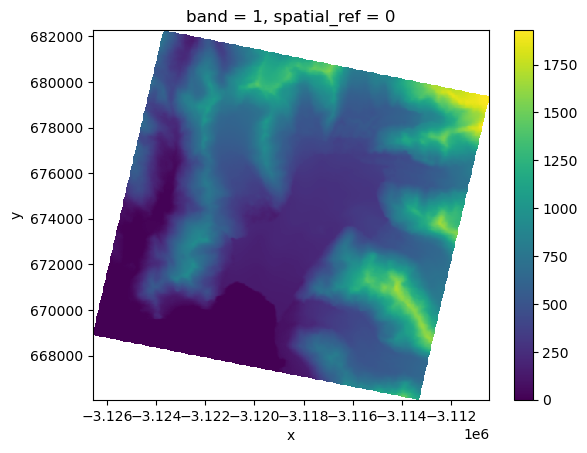

In [28]:
cop30_xds.where(cop30_xds != cop30_xds.rio.nodata).plot()

In [29]:
land_info = PCCollectionInfo(
    collection="io-lulc-annual-v02",
    asset_stac_key="data",
    docs_url="https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02",
)

In [30]:
land_items = search_planetary_computer_stac(
    collection=land_info.collection,
    features=aoi,
)
land_items

In [31]:
DATA_DIR = Path(__name__).parent / "data"

# Extract collection constants to local variable for readability
collection = land_info.collection
url = land_info.get_asset_url(item=land_items[0])

# Define the destination path for each raster stage
downloaded_dst = DATA_DIR / "background" / f"{collection}.tif"
clipped_dst = DATA_DIR / "background" / f"{collection}-clipped.tif"
reprojected_dst = DATA_DIR / "background" / f"{collection}-proj.tif"


# Download the source raster
if not downloaded_dst.exists():
    # Only run if the destination raster doesn't already exist
    download_raster(url=url, dst=downloaded_dst)

# Clip the downloaded raster to the project AOI
if not clipped_dst.exists():
    # Only run if the destination raster doesn't already exist
    clip_raster(src=downloaded_dst, dst=clipped_dst, aoi=aoi)

# Reproject the clipped raster to the same projection as the strips
if not reprojected_dst.exists():
    # Only run if the destination raster doesn't already exist
    reproject_raster(
        src=clipped_dst,
        dst=reprojected_dst,
        dst_epsg=3413,
        dst_nodata=0,
        resampling_method=Resampling.bilinear,
    )

# Store the path to the reprojected raster to a named variable that won't be overwritten
land_raster = reprojected_dst

In [32]:
land_xds = rioxarray.open_rasterio(filename=land_raster)

In [33]:
land_xds

<xarray.DataArray (band: 1, y: 1557, x: 1557)>
[2424249 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -3.127e+06 -3.127e+06 ... -3.11e+06 -3.11e+06
  * y            (y) float64 6.822e+05 6.822e+05 ... 6.661e+05 6.661e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

In [34]:
import rasterio
import numpy as np
from matplotlib.colors import ListedColormap


def get_land_colormap(asset_url: str) -> ListedColormap:
    # The code below is adapted from the example notebook for the same data source
    # https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02#Example-Notebook
    class_names = {
        "No Data": 0,
        "Water": 1,
        "Trees": 2,
        "Flooded vegetation": 4,
        "Crops": 5,
        "Built area": 7,
        "Bare ground": 8,
        "Snow/ice": 9,
        "Clouds": 10,
        "Rangeland": 11,
    }

    with rasterio.open(asset_url) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 255
            for i in range(max(class_names.values()) + 1)
        ]  # transform to matplotlib color format

    return ListedColormap(colormap)

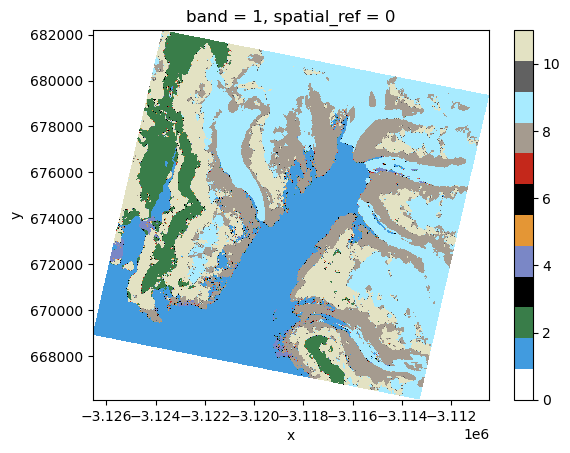

In [35]:
# TODO: Add cmap labels
land_cmap = get_land_colormap(url)
land_xds.plot(cmap=land_cmap)

## Coregister Strip DEMs

In [36]:
from pathlib import Path

DATA_DIR = Path(__name__).parent / "data"

DEM_2012_PATH = DATA_DIR / "strips/2012-08-13.tif"
DEM_2018_PATH = DATA_DIR / "strips/2018-04-16.tif"
DEM_REF_PATH = DATA_DIR / "background/cop-dem-glo-30-proj.tif"
LAND_REF_PATH = DATA_DIR / "background/io-lulc-annual-v02-proj.tif"

In [37]:
from pathlib import Path
import rioxarray


def extract_stable_ground_raster(src: Path, dst: Path, extract_value: int) -> Path:
    # Load the raster to extract values from
    xds = rioxarray.open_rasterio(filename=src)

    # Filter the cell values to only those in the specified value
    xds = xds.where(xds == extract_value)

    # Write the extracted raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the extracted raster
    return dst

In [38]:
stable_ground_path = DATA_DIR / "background/io-lulc-annual-v02-proj-ground.tif"

extract_stable_ground_raster(src=LAND_REF_PATH, dst=stable_ground_path, extract_value=8)

PosixPath('data/background/io-lulc-annual-v02-proj-ground.tif')

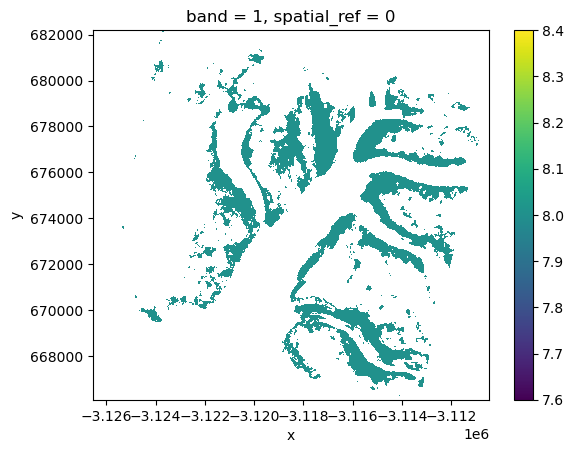

In [39]:
stable_ground = rioxarray.open_rasterio(stable_ground_path)
stable_ground.plot()

In [40]:
import geoutils
import xdem

dem_2012 = xdem.DEM(filename_or_dataset=DEM_2012_PATH)
dem_2018 = xdem.DEM(filename_or_dataset=DEM_2018_PATH)
dem_ref = xdem.DEM(filename_or_dataset=DEM_REF_PATH).reproject(dst_ref=dem_2012)
stable_ground_mask = geoutils.Mask(stable_ground_path).reproject(
    dst_ref=dem_2012, src_nodata=0
)

In [41]:
nuth_kaab = xdem.coreg.NuthKaab()

nuth_kaab.fit(
    reference_dem=dem_ref, dem_to_be_aligned=dem_2012, inlier_mask=stable_ground_mask
)

dem_2012_coreg = nuth_kaab.apply(dem=dem_2012)

In [42]:
ddem = dem_2012_coreg - dem_2012
print(ddem.info(stats=True))

Driver:               None 
Opened from file:     None 
Filename:             None 
Loaded?               True 
Modified since load?  True 
Size:                 5717, 5716
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:3413']
NoData Value:         -9999.0
Pixel Size:           2.0, 2.0
Upper Left Corner:    -3124226.0, 668428.0
Lower Right Corner:   -3112792.0, 679860.0
[MAXIMUM]:          -9.10
[MINIMUM]:          -18.22
[MEDIAN]:           -14.01
[MEAN]:             -13.99
[STD DEV]:          0.31



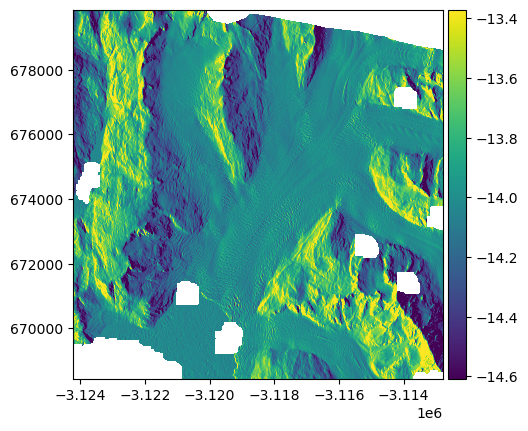

In [43]:
mean = -13.99
std_dev = 0.31
vmin = mean - 2 * std_dev
vmax = mean + 2 * std_dev
ddem.show(vmin=vmin, vmax=vmax)

## Visualizing Change with Differencing

In [44]:
# TODO: Subtract dem_2018 from dem_2012

## Things to try next

- Look at more than two DEMs
- Extract glacier terminus from rasters